/anaconda3/envs/hddm/lib/python3.5/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
/anaconda3/envs/hddm/lib/python3.5/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in less
100%|██████████| 3844/3844 [00:30<00:00, 124.53it/s]


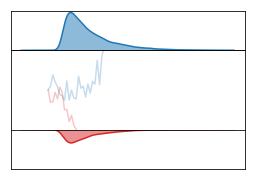

In [3]:
#plot the drift ... and the diffusion. 
#code from the cracked bassoon. 
import hddm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm


def setupfig():
    """Tweak for the target journal.
    """
    single_column = (3.346, 2.301)
    fig = plt.figure(figsize=single_column)
    gs = GridSpec(3, 1, height_ratios=[1, 2, 1], hspace=0)
    return fig, gs


def delabel(ax):
    """Strip labels.
    """
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


def kde(ax, x, mx, c):
    """Plot a KDE for reaction times.
    """
    x = x[x <= mx]
    bandwidth = .8 * x.std() * x.size ** (-1 / 5.)
    support = np.linspace(0, mx, 500)
    kernels = []

    for x_i in tqdm(x):

        kernel = norm(x_i, bandwidth).pdf(support)
        kernels.append(kernel)
        density = np.sum(kernels, axis=0)

    my = np.max(density)
    ax.plot(support, density, c=c)
    ax.fill_between(support, 0, density, alpha=.5, facecolor=c)
    ax.set_ylim(0, my * 1.05)
    delabel(ax)

    return my


def traces(ax, n, mx, **params):
    """Draw example of diffusions.
    """
    x = np.linspace(0, mx, 101)
    delta = x[1]
    nd_samples = np.round(params['t'] / delta).astype(int)
    d_samples = len(x) - nd_samples
    y0 = np.zeros(nd_samples) * np.nan
    y0[-1] = 0

    for i in range(n):

        y1 = np.cumsum(
            norm.rvs(params['v'] * delta, np.sqrt(delta), size=d_samples))
        y = params['a'] * params['z'] + np.concatenate([y0, y1])

        try:

            idx1 = np.where(y > params['a'])[0][0] + 1

        except:

            idx1 = np.inf

        try:

            idx2 = np.where(y < 0)[0][0] + 1

        except:

            idx2 = np.inf

        if idx1 < idx2:

            y[idx1:] = np.nan
            ax.plot(x, y, c='C0', zorder=-12, alpha=.25)

        if idx2 < idx1:

            y[idx2:] = np.nan
            ax.plot(x, y, c='C3', zorder=-11, alpha=.25)

        ax.set_ylim(0, params['a'])
        ax.set_xlim(0, mx)
        delabel(ax)


def ddmfig(**params):
    """Draw a DDM plot with the given parameter values.
    """
    mx = 3.5
    size = 15000
    ntraces = 2

    # set up fig
    fig, gs = setupfig()

    # traces
    ax = plt.subplot(gs[1])
    traces(ax, ntraces, mx, **params)

    # data for kdes
    df, _ = hddm.generate.gen_rand_data(params, subjs=1, size=size)

    # top KDE
    ax = plt.subplot(gs[0])
    my = kde(ax, df[df.response == 1].rt.values, mx, 'C0')

    # bottom KDE
    ax = plt.subplot(gs[2])
    kde(ax, df[df.response == 0].rt.values, mx, 'C3')
    ax.set_ylim(0, my * 1.05)
    ax.invert_yaxis()

    # remove whitespace around fig
    plt.tight_layout(0)


def main():

    np.random.seed(25)
    ddmfig(v=0.7, a=1.5, t=0.6, z=0.5)
    plt.savefig('tmp.pdf')


if __name__ == '__main__':

    main()